In [1]:
import os
import dotenv
dotenv.load_dotenv()

True

In [5]:
urls = [
    "https://www.nutmeg.com/nutmegonomics/our-2025-investment-outlook",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-november-2024",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-october-2024"
]


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

print(len(doc_splits))
doc_splits[10].page_content[12:96]

26


"In sum, while the outlook is promising, we're prepared for any shifts in the market."

In [6]:
import google.generativeai as genai
genai.configure(api_key=os.getenv("GOOGLE_API_KEY")) #https://aistudio.google.com/app/apikey

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embd = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

c:\Users\Hp\Documents\personal\New Folder\GenAI\mygenai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.2)

In [33]:
from pydantic import BaseModel, Field
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )
    
structured_llm_router = llm.with_structured_output(RouteQuery)
    
# Prompt
ROUTER_PROMPT = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to 2025, new year investment outlook by nutmeg.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
from langchain_core.prompts import ChatPromptTemplate
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ROUTER_PROMPT),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

question_router.invoke({"question": "what's new in the 2025, which stock I should watch?"})

RouteQuery(datasource='vectorstore')

In [14]:
class GradeDocuments(BaseModel):
    """Binary Score Yes and No for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
    
structured_llm_grader = llm.with_structured_output(GradeDocuments)

BINARY_PROMPT = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", BINARY_PROMPT),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

scorer = grade_prompt | structured_llm_grader

scorer.invoke({"document": "The new AI agents are designed to be more efficient and effective in their tasks.",
               "question": "What are the new agents?"})

GradeDocuments(binary_score='yes')

In [15]:
question = "what's your thought on apple stock?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[-1].page_content
scorer.invoke({"question": question, "document": doc_txt})

GradeDocuments(binary_score='no')

In [16]:
from langchain_core.output_parsers import StrOutputParser
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question. Just give me the question",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"What is your analysis of Apple Inc.'s stock performance and future outlook?"

In [17]:
from langchain import hub


# Pull the prompt from Langchain's hub
prompt = hub.pull("rlm/rag-prompt", api_key=os.getenv('LANGCHAIN_API_KEY'))

# Chain for generation
rag_chain = prompt | llm | StrOutputParser()

# Run generation with context (relevant documents) and the user's question
generation = rag_chain.invoke({"context": docs, "question": question})

print(generation)

The retrieved context does not provide specific insights or opinions on Apple stock. It emphasizes the importance of conducting your own research and acknowledges the risks associated with investing. Therefore, I don't have a definitive thought on Apple stock.


In [18]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeHallucinations)
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [19]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

In [20]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """Defines the state structure for the graph flow."""
    question: str  # The original or rewritten user question
    generation: str  # The answer generated by the system
    documents: List[str]  # The list of documents retrieved for the question

   
from langgraph.graph import START, END , StateGraph
workflow = StateGraph(GraphState)  

In [21]:
def retrieve(state: GraphState):
    print("--RETRIEVING--")
    question = state["question"]
    documents = retriever.invoke(question)  # Fetch documents from the vector database
    return {"documents": documents, "question": question}

workflow.add_node("retrieve", retrieve)  # Add retriever node to the workflow

In [22]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=1)  # Configure Tavily search tool
def web_search(state):
    print("-- DOING WEB SEARCH --")
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})  # Perform the web search
    web_results = "\n".join([d["content"] for d in docs])  # Combine the results into a single document
    web_results = Document(page_content=web_results)
    return {"documents": web_results, "question": question}

workflow.add_node("web_search", web_search)  # Add web search node to the workflow


In [23]:
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})  # Query router determines the data source
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    

# Build the graph with conditional edges
workflow.add_conditional_edges(
    START,  # Start of the workflow
    route_question,  # Route the question using the query router
    {
        "web_search": "web_search",  # Route to web search node
        "vectorstore": "retrieve",  # Route to retriever node
    },
)


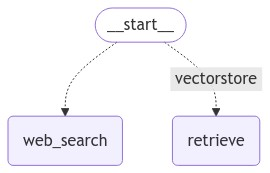

In [19]:
# app = workflow.compile()  # Compile the workflow

# from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
def grade_document(state):
    """
    Grades the retrieved documents for relevance.

    Args:
        state (dict): Current graph state containing the question and retrieved documents.

    Returns:
        dict: Updated state with only relevant documents.
    """
    print("----CHECKING DOCUMENT RELEVANCE----")
    documents = state["documents"]
    relevant_docs = []  
    question = state["question"]

    for d in documents:
        score = scorer.invoke({"question": question, "document": d.page_content})  # Use the scorer to grade documents
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            relevant_docs.append(d)  # Add relevant documents to the list
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"documents": relevant_docs, "question": question}  # Return relevant documents with the question

# Add the node to the workflow
workflow.add_node("grade_documents", grade_document)
# Add an edge from retriever to document grader
workflow.add_edge("retrieve", "grade_documents")


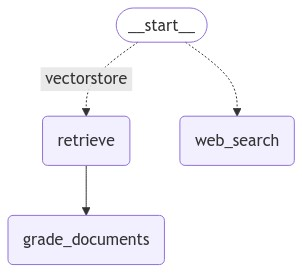

In [25]:
# app = workflow.compile()  # Compile the workflow

# from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
def transform_query(state):
    print("--TRANSFORMING THE QUERY--")
    question = state["question"]
    documents = state["documents"]
    better_question = question_rewriter.invoke({"question":question})
    return {"documents": documents, "question": better_question}

workflow.add_node("transform_query", transform_query)
workflow.add_edge("transform_query", "retrieve")

In [26]:
def generate(state):
    print("--GENERATE--")
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context":documents , "question":question})
    return {"documents": documents , "question":question , "generation":generation}

workflow.add_node("generate", generate)

workflow.add_edge("web_search", "generate")

In [27]:
def decide_to_generate(state):
    """
    decides to whether to generate the answer or to re-generate the question
    """
    print("--ASSESSING THE RELEVANT DOCUMENTS --")
    question = state["question"]
    relevant_docs = state["documents"]
    if not relevant_docs :
      print("--DECISION : ALL THE DOCUMENT FOUND ARE NOT RELEVANT TO THE QUERY , SO WE NEED TO TRANSFORM IT ")
      return "transform_query"
    else:
      print("--DECISION : GENERATE THE ANSWER")
      return "generate"
  
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
  

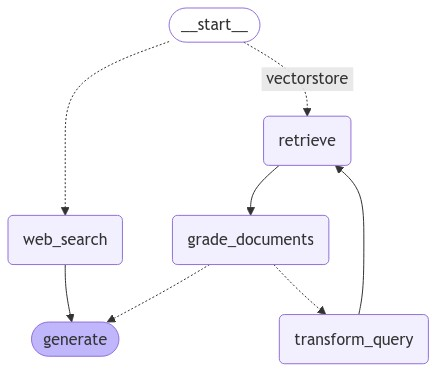

In [ ]:
# app = workflow.compile()  # Compile the workflow

# from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
def grade_generation_v_documents_and_question(state):
  print("--CHECKING THE HALLUCINATIONS--")
  question = state["question"]
  generation = state["generation"]
  documents = state["documents"]

  score = hallucination_grader.invoke({"documents": documents , "generation": generation})
  grade = score.binary_score
  if grade == "yes":
    print("---GENERATION IS GROUNDED IN THE DOCUMENTS--- ")
    print("--GRADING GENERATION VS QUESTION--")
    score = answer_grader.invoke({"question" :question , "generation" : generation})
    grade = score.binary_score
    if grade == "yes":
      print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
      # Check question-answering
      print("---GRADE GENERATION vs QUESTION---")
      score = answer_grader.invoke({"question": question, "generation": generation})
      grade = score.binary_score
      if grade == "yes":
          print("---DECISION: GENERATION ADDRESSES QUESTION---")
          return "useful"
      else:
          print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
          return "not useful"
    else:
      print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
      return "not supported"

In [29]:
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)


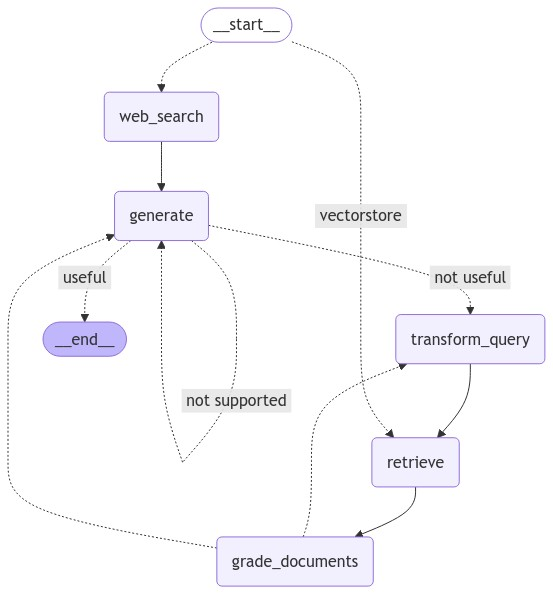

In [30]:
app = workflow.compile()  # Compile the workflow

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
from pprint import pprint
inputs = {
    "question": "what's new in the 2025, which stock I should watch?"
}

for output in app.stream(inputs, stream_mode="values"):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        # Ensure 'generation' key exists
        if "generation" in value:
            pprint(value["generation"])
        else:
            pprint("No generation found at this step.")
    print(output)
    print("\n---\n")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
"Node 'question':"
'No generation found at this step.'
{'question': "what's new in the 2025, which stock I should watch?"}

---

--RETRIEVING--
"Node 'question':"
'No generation found at this step.'
"Node 'documents':"
'No generation found at this step.'
{'question': "what's new in the 2025, which stock I should watch?", 'documents': [Document(metadata={'description': 'The Nutmeg investment team give their views ahead of the new year', 'language': 'en', 'source': 'https://www.nutmeg.com/nutmegonomics/our-2025-investment-outlook', 'title': 'Our 2025 investment outlook - Nutmeg'}, page_content="2024. But the extent of easing will depend on this balance of demand strength and resultant inflationary pressures.Our cautiously optimistic view that central banks will continue their rate cut cycle means\xa0we have a modest overweight in bond exposure across our portfolios. Bond prices typically have an inverse relationship with policy rates and t